In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)

import pmdarima as pm


In [105]:
url = "https://storage.googleapis.com/safetymap/preprocessed_data2.csv"
df = pd.read_csv(url)
df.drop(columns = "colonia_id", inplace = True)

In [106]:
df

,alcaldia_colonia,año_mes_hecho,burglary,danger of well-being,domestic violence,fraud,homicide,property damage,robbery with violence,robbery without violence,sexual crime,threats
0,ALVARO OBREGON || 16 DE SEPTIEMBRE,2019-01-01,0,0,0,0,0,0,0,0,0,0
1,ALVARO OBREGON || 16 DE SEPTIEMBRE,2019-02-01,0,0,0,0,0,0,0,0,0,0
2,ALVARO OBREGON || 16 DE SEPTIEMBRE,2019-03-01,0,0,0,0,0,0,0,0,0,0
3,ALVARO OBREGON || 16 DE SEPTIEMBRE,2019-04-01,0,0,0,0,0,0,0,0,0,0
4,ALVARO OBREGON || 16 DE SEPTIEMBRE,2019-05-01,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
104086,XOCHIMILCO || XICALHUACAN,2022-11-01,1,0,0,0,0,0,0,0,0,1
104087,XOCHIMILCO || XICALHUACAN,2022-12-01,0,0,0,0,0,0,0,1,0,1
104088,XOCHIMILCO || XICALHUACAN,2023-01-01,0,1,1,0,0,1,0,0,0,1
104089,XOCHIMILCO || XICALHUACAN,2023-02-01,0,0,0,0,0,0,0,0,0,0


In [107]:
pre_data = df.set_index(["año_mes_hecho","alcaldia_colonia"]).unstack("alcaldia_colonia")

## train test split

In [108]:
group = df.groupby("año_mes_hecho")["burglary"].count()
group.pipe(lambda x: x.cumsum()/x.sum()*100)

año_mes_hecho
2019-01-01      1.960784
2019-02-01      3.921569
2019-03-01      5.882353
2019-04-01      7.843137
2019-05-01      9.803922
2019-06-01     11.764706
2019-07-01     13.725490
2019-08-01     15.686275
2019-09-01     17.647059
2019-10-01     19.607843
2019-11-01     21.568627
2019-12-01     23.529412
2020-01-01     25.490196
2020-02-01     27.450980
2020-03-01     29.411765
2020-04-01     31.372549
2020-05-01     33.333333
2020-06-01     35.294118
2020-07-01     37.254902
2020-08-01     39.215686
2020-09-01     41.176471
2020-10-01     43.137255
2020-11-01     45.098039
2020-12-01     47.058824
2021-01-01     49.019608
2021-02-01     50.980392
2021-03-01     52.941176
2021-04-01     54.901961
2021-05-01     56.862745
2021-06-01     58.823529
2021-07-01     60.784314
2021-08-01     62.745098
2021-09-01     64.705882
2021-10-01     66.666667
2021-11-01     68.627451
2021-12-01     70.588235
2022-01-01     72.549020
2022-02-01     74.509804
2022-03-01     76.470588
2022-04-01 

In [109]:
INPUT_LENGTH = 1 * 12 # records every 1 month x 12 months per year = 12 months

In [110]:
TRAIN_TEST_RATIO = 0.70

In [111]:
import pandas as pd
from typing import Tuple

def train_test_split(fold:pd.DataFrame,
                     train_test_ratio: float,
                     input_length: int) -> Tuple[pd.DataFrame]:
    """From a fold dataframe, take a train dataframe and test dataframe based on 
    the split ratio.
    - df_train should contain all the timesteps until round(train_test_ratio * len(fold))
    - df_test should contain all the timesteps needed to create all (X_test, y_test) tuples

    Args:
        fold (pd.DataFrame): A fold of timesteps
        train_test_ratio (float): The ratio between train and test 0-1
        input_length (int): How long each X_i will be

    Returns:
        Tuple[pd.DataFrame]: A tuple of two dataframes (fold_train, fold_test)
    """
    fold_train = fold[0:round(len(fold)*train_test_ratio)]
    fold_test = fold[(round(len(fold)*train_test_ratio - input_length)):]
    return fold_train,fold_test

In [245]:
(fold_train, fold_test) = train_test_split(pre_data, TRAIN_TEST_RATIO, INPUT_LENGTH)

## converting to X_train, y_train and X_test, y_test

In [246]:
print(df.columns)

Index(['alcaldia_colonia', 'año_mes_hecho', 'burglary', 'danger of well-being',
       'domestic violence', 'fraud', 'homicide', 'property damage',
       'robbery with violence', 'robbery without violence', 'sexual crime',
       'threats'],
      dtype='object')


In [247]:
def get_X_y_strides(fold: pd.DataFrame, input_length: int, output_length: int, 
    sequence_stride: int) -> Tuple[np.array]:
    """slides through a `fold` Time Series (2D array) to create sequences of equal
        * `input_length` for X,
        * `output_length` for y,
    using a temporal gap `sequence_stride` between each sequence

    Args:
        fold (pd.DataFrame): One single fold dataframe
        input_length (int): Length of each X_i
        output_length (int): Length of each y_i
        sequence_stride (int): How many timesteps to take before taking the next X_i

    Returns:
        Tuple[np.array]: A tuple of numpy arrays (X, y)
    """
    X, y = [], []

    for i in range(0, len(fold), sequence_stride):
        # Exits the loop as soon as the last fold index would exceed the last index
        if (i + input_length + output_length) >= len(fold):
            break
        X_i_transformed = fold.iloc[i:i + input_length, :]
        y_i_transformed = fold.iloc[i + input_length:i + input_length + output_length, :][TARGET]


        fold_train_list = X_i_transformed.stack("alcaldia_colonia").groupby(["alcaldia_colonia", "año_mes_hecho"])\
                            .apply(lambda x: x.values.tolist()[0])\
                            .groupby("alcaldia_colonia").apply(lambda x: x.values.tolist())\
                            .tolist()

        fold_test_list = y_i_transformed.stack("alcaldia_colonia").groupby(["alcaldia_colonia", "año_mes_hecho"])\
                            .apply(lambda x: x.values.tolist()[0])\
                            .groupby("alcaldia_colonia").apply(lambda x: x.values.tolist())\
                            .tolist()

    return (np.array(fold_train_list), np.array(fold_test_list))

In [273]:
SEQUENCE_STRIDE = 1
OUTPUT_LENGTH = 2
TARGET = ['burglary', 'danger of well-being',
       'domestic violence', 'fraud', 'homicide', 'property damage',
       'robbery with violence', 'robbery without violence', 'sexual crime',
       'threats']

In [274]:
X_train, y_train = get_X_y_strides(fold_train, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)
X_test, y_test = get_X_y_strides(fold_test, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)


In [275]:
X_train.shape

(2041, 12, 10)

In [276]:
y_train.shape

(2041, 2, 10)

## Model

In [277]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.layers.experimental.preprocessing import Normalization

def init_model(X_train, y_train):
    model = Sequential()
    #normalizer = Normalization() # Instantiate a "normalizer" layer
    #normalizer.adapt(X_train) # "Fit" it on the train set
    
    # –– Model
    #model.add(normalizer)
    model.add(layers.Masking(mask_value=-1, input_shape=(12,10)))
    model.add(layers.LSTM(units=40, activation='tanh', return_sequences =False))
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dropout(rate=0.2))  # The rate is the percentage of neurons that are "killed"
    model.add(layers.Dense(2, activation='relu'))

    # –– Compilation
    model.compile(loss='mse', 
                  optimizer='adam',
                 metrics = ["mae"]) 

    return model 

In [278]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=10)

model = init_model(X_train, y_train)
model.summary()
history = model.fit(X_train, y_train, 
          epochs=200, 
          batch_size=32, 
          verbose=1, 
          callbacks = [es],
          validation_split=0.2)

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_37 (Masking)        (None, 12, 10)            0         
                                                                 
 lstm_36 (LSTM)              (None, 40)                8160      
                                                                 
 dense_81 (Dense)            (None, 50)                2050      
                                                                 
 dropout_37 (Dropout)        (None, 50)                0         
                                                                 
 dense_82 (Dense)            (None, 2)                 102       
                                                                 
Total params: 10312 (40.28 KB)
Trainable params: 10312 (40.28 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200


ValueError: in user code:

    File "/Users/angelescobedo1712/.pyenv/versions/Safety-map/lib/python3.10/site-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/Users/angelescobedo1712/.pyenv/versions/Safety-map/lib/python3.10/site-packages/keras/src/engine/training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/angelescobedo1712/.pyenv/versions/Safety-map/lib/python3.10/site-packages/keras/src/engine/training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "/Users/angelescobedo1712/.pyenv/versions/Safety-map/lib/python3.10/site-packages/keras/src/engine/training.py", line 1081, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/angelescobedo1712/.pyenv/versions/Safety-map/lib/python3.10/site-packages/keras/src/engine/training.py", line 1139, in compute_loss
        return self.compiled_loss(
    File "/Users/angelescobedo1712/.pyenv/versions/Safety-map/lib/python3.10/site-packages/keras/src/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/angelescobedo1712/.pyenv/versions/Safety-map/lib/python3.10/site-packages/keras/src/losses.py", line 142, in __call__
        losses = call_fn(y_true, y_pred)
    File "/Users/angelescobedo1712/.pyenv/versions/Safety-map/lib/python3.10/site-packages/keras/src/losses.py", line 268, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/angelescobedo1712/.pyenv/versions/Safety-map/lib/python3.10/site-packages/keras/src/losses.py", line 1608, in mean_squared_error
        return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)

    ValueError: Dimensions must be equal, but are 32 and 2 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](sequential_37/dense_82/Relu, mean_squared_error/Cast)' with input shapes: [32,2], [32,2,10].


In [263]:
model.evaluate(X_test,y_test)

64/64 [==============================] - 0s 919us/step - loss: 1.5974 - mae: 0.6425


[1.5973514318466187, 0.6425103545188904]

In [264]:
def plot_history(history):
    
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    # --- LOSS: MSE --- 
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('MSE')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- METRICS:MAE ---
    
    ax[1].plot(history.history['mae'])
    ax[1].plot(history.history['val_mae'])
    ax[1].set_title('MAE')
    ax[1].set_ylabel('MAE')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='best')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
                        
    return ax

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

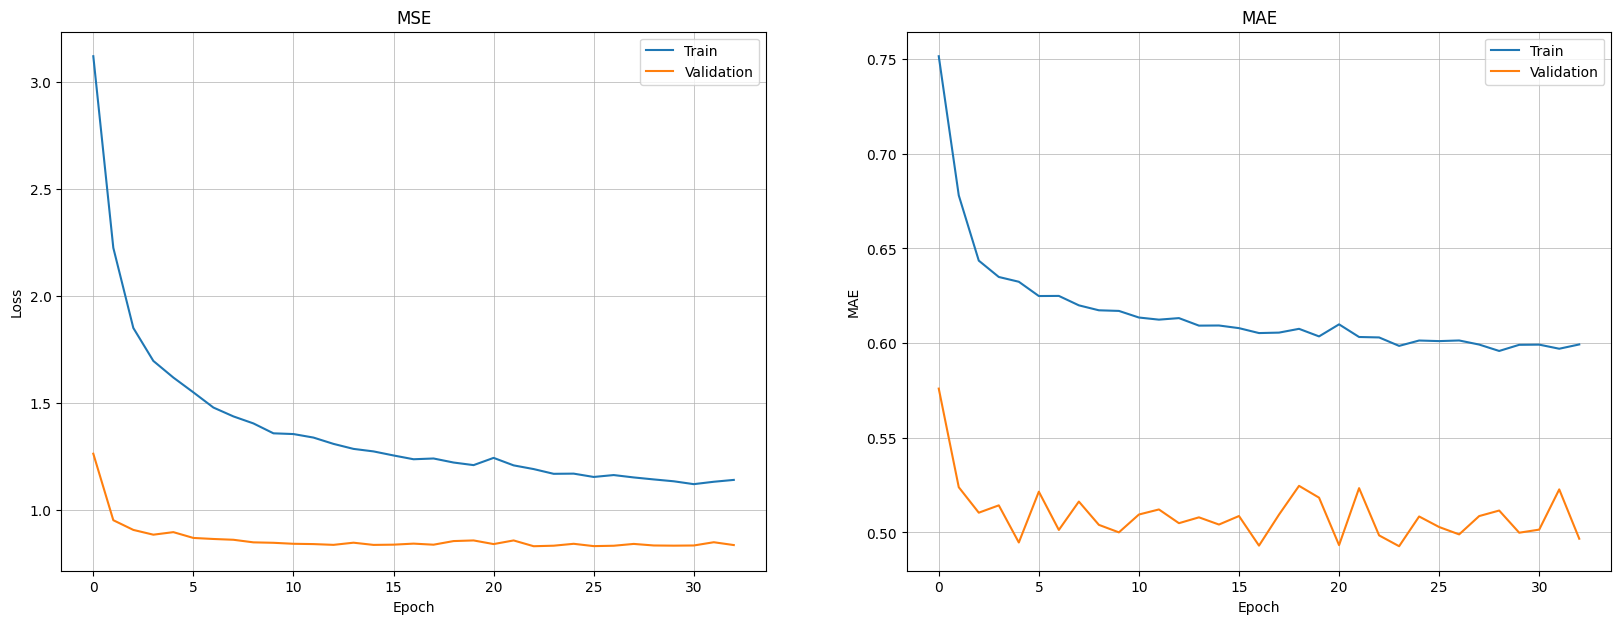

In [265]:
plot_history(history)

In [268]:
predictions = model.predict(X_test)

64/64 [==============================] - 0s 850us/step


In [272]:
predictions[0]

array([[0.05232186, 0.06879766, 0.24259174, 0.11218908, 0.02550339,
        0.03546767, 0.07045834, 0.12478779, 0.03516114, 0.11261928],
       [0.01981528, 0.03707592, 0.1621537 , 0.0718825 , 0.01736877,
        0.01351795, 0.03038207, 0.07178308, 0.01498783, 0.06727052],
       [0.00055577, 0.02907534, 0.1249859 , 0.07008255, 0.0126698 ,
        0.00305294, 0.00981133, 0.05492708, 0.00311395, 0.05148414],
       [0.        , 0.02158922, 0.09820199, 0.05915742, 0.00884324,
        0.        , 0.        , 0.03533691, 0.        , 0.03821056],
       [0.        , 0.01294221, 0.07512397, 0.04235145, 0.00522051,
        0.        , 0.        , 0.012835  , 0.        , 0.02358326],
       [0.        , 0.00259743, 0.05062038, 0.02153447, 0.00083833,
        0.        , 0.        , 0.        , 0.        , 0.00655659],
       [0.        , 0.        , 0.02401143, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.       